In [24]:
# Standard libraries
import numpy as np
from scipy import sparse
import scipy.io as sp
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# scikit-learn
from sklearn.datasets import (make_blobs, make_circles)
from sklearn.utils import shuffle
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.decomposition import PCA

import cvxpy as cvx
from cvxpy.atoms.elementwise.power import power

In [25]:
%pip install cvxpy

In [26]:

random_seed = 42
plot_colors = cm.tab10.colors
     

In [27]:
# tạo ma trận Y có N điểm và D chiều , i là điểm sử dụng SSC 
def find_sparse_sol(Y,i,N,D):
  if i == 0:
    # nếu i =0 lấy tất cả các đieerm sau i
    Ybari = Y[:,1:N]# ybari là ma trận con của Y loại bỏ điểm thứ i
  if i == N-1:
    # nếu i là điểm cuối thì lấy tất cả các điểm trừ điểm cuối
    Ybari = Y[:,0:N-1]
  if i!=0 and i!=N-1:
    #nếu i ở giữ lấy tất cả các điểm trước và sau i
    Ybari = np.concatenate((Y[:,0:i],Y[:,i+1:N]),axis=1)

  # xác định điểm Yi tương ứng với chỉ số i trên ma trận Y
  yi = Y[:,i].reshape(D,1)

  # Sử dụng thư viện cvxpy để giải bài toán tối ưu l1
  # min (||yi - Ybari*ci||F)^2 + lambda*||ci||1   st. sum(ci) = 1
  ci = cvx.Variable(shape=(N-1,1))#tạo  ci có kích thước N-1 là giải pháp cần tìm
  constraint = [cvx.sum(ci)==1]#ràng buộc tổng thành phần ci = 1
  # a penalty in the 2-norm of the error is added to the l1 norm to account for noisy data
  obj = cvx.Minimize(power(cvx.norm(yi-Ybari@ci,2),2) + 0.082*cvx.norm(ci,1)) #lambda = 0.082
  prob = cvx.Problem(obj, constraint)#giảm thiểu sai số giữa yi và Ybari*ci
  prob.solve()
  return ci.value #trả giá trị về ci

In [28]:
#tạo ma trận kề cho bộ dữ liệu
def make_adjacency(dataset):
  """
  Returns SSC adjacency
  """
  X = dataset['X']#ma trận dữ liệu
  y = dataset['y']#nhãn
  y_colors = dataset['y_colors']#màu theo nhãn y

  N = X.shape[0]
  D = X.shape[1]
  C = np.concatenate((np.zeros((1,1)),find_sparse_sol(X.T,0,N,D)),axis=0)#ma trận chứa thông tin về sự tương đồng  giữa các điểm dữ liệu

  for i in range(1,N):
    ci = find_sparse_sol(X.T,i,N,D)#tìm các giải pháp tối ưu ci
    zero_element = np.zeros((1,1))
    cif = np.concatenate((ci[0:i,:],zero_element,ci[i:N,:]),axis=0)#ghép các ci lại
    C = np.concatenate((C,cif),axis=1)#ghép các ci lại theo hàng ngang

  # tìm giá trị tối đa của mỗi hàng và đặt giá trị không phải max bằng 0 trong ma trận C
  max_idx = 1   # số lượng giá trị tối đa muốn giữ lại trong mỗi hàng
  mask = np.argpartition(-C, max_idx-1, axis=0) # tìm vị trí của giá trị tối đa
  mask = mask > max_idx-1 #tạo một mảng chứa cấc vị trí ko phải tối đa
  C[mask] = 0 # đặt các giá trị ko phải tối đa bằng 0

  # tạo ma trận liền kề của C 
  W = np.add(np.absolute(C), np.absolute(C.T))
  # d chứa các thông tin X , y , y_color và ma trận kề W

  d = {'X': X, 'y': y, 'y_colors': y_colors, 'W': W}

  return d

In [29]:
#tải dữ bộ dữ liệu iris( bộ dữ liệu thường được dùng để sử dụng trong các bài toán phân cụm đa lớp)
iris = datasets.load_iris()
#gán dữ liệu iris vào biến x
X = iris.data
#sử dụng PCA(Principal Component Analysis) để giảm chiều dữ liệu xuống 2D
X = PCA(n_components=2).fit_transform(X)
#biến y chứa các lớp của bộ dữ liệu ( 0 ,1 hoặc 2)
y = iris.target
y_colors = np.array(plot_colors)[y]
#tạo từ điển iris_dataset 
iris_dataset = {'X': X, 'y': y, 'y_colors': y_colors}

In [30]:
#tạo ma trận liền kề cho bộ dữ liệu iris_dataset
iris_dataset = make_adjacency(iris_dataset)

In [31]:
#sử dụng ssc để phân cụm Quang phổ với số chiều là 3 , sử dụng kmeans để gán nhãn , sử dụng ma trận kề W đề làm độ tương đồng
clustering = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans', random_state=random_seed).fit(iris_dataset['W'])
clustering_colors = np.array(plot_colors)[clustering.labels_]

C:\Users\Admin\Documents\anaconda\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\Admin\Documents\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


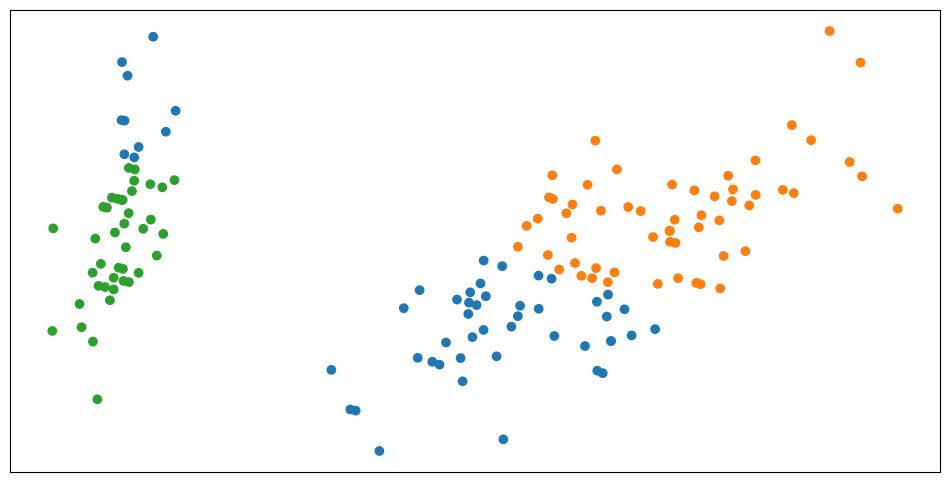

In [32]:
fig, axs = plt.subplots(1, figsize=(12, 6))

axs.scatter(X[:, 0], X[:, 1], color=clustering_colors)
axs.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
          labelbottom=False,labeltop=False,labelleft=False,labelright=False);
axs.set(xlabel=None, ylabel=None)


plt.show()

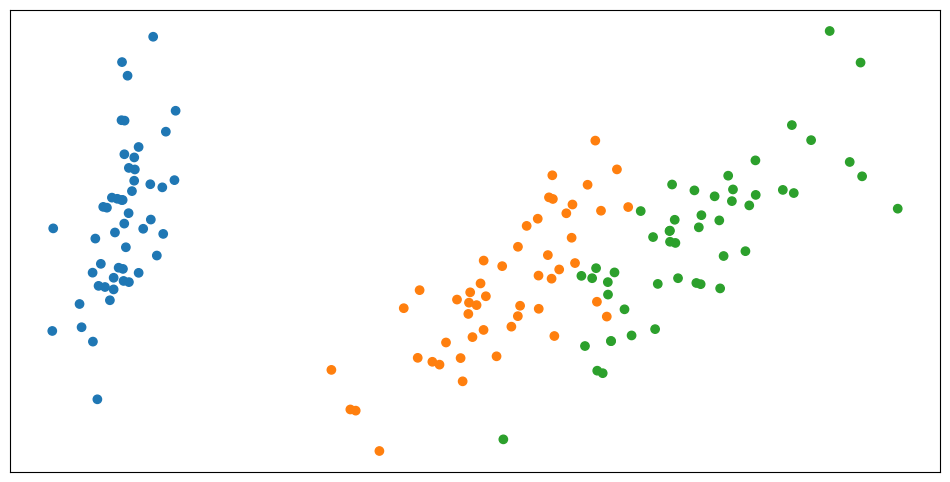

In [33]:
fig, axs = plt.subplots(1, figsize=(12, 6))

axs.scatter(X[:, 0], X[:, 1], color=y_colors)
axs.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
          labelbottom=False,labeltop=False,labelleft=False,labelright=False);
axs.set(xlabel=None, ylabel=None)

plt.show()